<a href="https://colab.research.google.com/github/RomanTomz/Rome-RTA-Complete/blob/master/RTA_Rome_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install geojson
! pip install geopandas


     |████████████████████████████████| 972kB 2.8MB/s 
     |████████████████████████████████| 14.8MB 242kB/s 
     |████████████████████████████████| 10.9MB 51.3MB/s 


In [265]:
import pandas as pd
import numpy as np

import glob
import geojson
import plotly
import geopandas as gpd
import json
import plotly.graph_objects as go
import plotly.express as px 
import seaborn as sns
import matplotlib.pyplot as plt

from folium import plugins
from folium.plugins import HeatMap
import folium
#pd.options.plotting.backend = 'plotly'





# Data Import and Prep

In [3]:
df = pd.concat([pd.read_csv(f,  sep=';', encoding='latin1', parse_dates=['DataOraIncidente']) for f in glob.glob('/content/drive/My Drive/Colab Notebooks/Roma/Inc_Roma_2019/data/csv_incidenti_*.csv')])


In [4]:
df.drop_duplicates(subset='Protocollo', inplace=True)
df.DataOraIncidente = pd.to_datetime(df.DataOraIncidente)
df.sort_values('DataOraIncidente', inplace=True)
df = df[df.NUM_FERITI != 'Sufficiente']
df.NUM_FERITI = df.NUM_FERITI.astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148034 entries, 44 to 7027
Data columns (total 40 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Protocollo              148034 non-null  int64         
 1   Gruppo                  148034 non-null  int64         
 2   DataOraIncidente        148034 non-null  datetime64[ns]
 3   Localizzazione1         145996 non-null  object        
 4   STRADA1                 148034 non-null  object        
 5   Localizzazione2         148034 non-null  object        
 6   STRADA2                 50569 non-null   object        
 7   Strada02                111015 non-null  object        
 8   Chilometrica            60446 non-null   object        
 9   DaSpecificare           37019 non-null   object        
 10  NaturaIncidente         148030 non-null  object        
 11  particolaritastrade     145966 non-null  object        
 12  TipoStrada              145980 

In [6]:
viario = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Roma/Inc_Roma_2019/data/viario.csv', encoding='latin1', sep=';', header=None, usecols=[0,1,2])

In [7]:
viario.rename(columns={0:'municipio',1:'codice',2:'denominazione'}, inplace=True)

In [8]:
viario.denominazione = viario.denominazione.str.strip()

In [9]:
viario

municipio  codice               denominazione
0            19  2357.0             VIA ABANO TERME
1            10  1126.0               VIA ABASCANTO
2            16  2530.0             VIA ABATE UGONE
3            20  2440.0   VIA ABBADIA SAN SALVATORE
4            19  2392.0           VIA ABBIATEGRASSO
...         ...     ...                         ...
30290        13  2048.0           VIA LUIGI CARDINI
30291        13  2048.0  VIA PAOLA ZANCANI MONTUORO
30292         8   627.0     VIA SAN PIETRO AVELLANA
30293        10  1191.0                 VIA ROZZANO
30294        13  2002.0                 VIA UCRAINA

[30295 rows x 3 columns]

In [10]:
df.STRADA1 = df.STRADA1.str.strip()

In [11]:
merged = pd.merge(df, viario, how='left', left_on='STRADA1', right_on='denominazione').drop_duplicates(subset='Protocollo').reset_index(drop=True)
merged.head(3)

Protocollo  Gruppo  ...  codice            denominazione
0     2242463       1  ...  1701.0  LUNGOTEVERE DEI TEBALDI
1     2252852       1  ...    13.0    VIA DI PORTA MAGGIORE
2     2245421      18  ...  1963.0    VIA DELLA MAGLIANELLA

[3 rows x 43 columns]

In [12]:
merged.columns

Index(['Protocollo', 'Gruppo', 'DataOraIncidente', 'Localizzazione1',
       'STRADA1', 'Localizzazione2', 'STRADA2', 'Strada02', 'Chilometrica',
       'DaSpecificare', 'NaturaIncidente', 'particolaritastrade', 'TipoStrada',
       'FondoStradale', 'Pavimentazione', 'Segnaletica',
       'CondizioneAtmosferica', 'Traffico', 'Visibilita', 'Illuminazione',
       'NUM_FERITI', 'NUM_RISERVATA', 'NUM_MORTI', 'NUM_ILLESI', 'Longitudine',
       'Latitudine', 'Confermato', 'Progressivo', 'TipoVeicolo',
       'StatoVeicolo', 'TipoPersona', 'Sesso', 'Tipolesione', 'Deceduto',
       'DecedutoDopo', 'CinturaCascoUtilizzato', 'Airbag', 'Unnamed: 37',
       'Longitude', 'Latitude', 'municipio', 'codice', 'denominazione'],
      dtype='object')

In [13]:
merged = merged[['Protocollo','DataOraIncidente','Localizzazione1','STRADA1','NaturaIncidente','particolaritastrade','TipoStrada','FondoStradale','Segnaletica','CondizioneAtmosferica','Traffico','Illuminazione','NUM_FERITI',
        'NUM_MORTI','NUM_ILLESI','Longitudine','Latitudine','TipoVeicolo','TipoPersona','Sesso','Tipolesione','DecedutoDopo','municipio']]

In [14]:
mun_feriti = merged.groupby('municipio')[['NUM_FERITI']].sum().reset_index(drop=False)

In [15]:
mun_feriti

municipio  NUM_FERITI
0          1        9160
1         10        3390
2         11        3873
3         12        3403
4         13        4119
5         15        2300
6         16        3433
7         17        3581
8         18        4504
9         19        2498
10         2        5798
11        20        3822
12         3        2555
13         4        2718
14         5        2496
15         6        3424
16         7        1964
17         8        4245
18         9        5720

# Prima Analisi

In [16]:
merged.head()

Protocollo    DataOraIncidente  ...  DecedutoDopo municipio
0     2242463 2015-01-01 00:40:00  ...  NON DECEDUTO         1
1     2252852 2015-01-01 00:45:00  ...           NaN         1
2     2245421 2015-01-01 01:00:00  ...           NaN        18
3     2242429 2015-01-01 01:20:00  ...           NaN        12
4     2242301 2015-01-01 02:30:00  ...  NON DECEDUTO        11

[5 rows x 23 columns]

In [17]:
hourly = merged.groupby(merged.DataOraIncidente.dt.hour)[['NUM_FERITI','NUM_MORTI']].sum()

In [18]:
fig = px.bar(hourly, x=hourly.index, y='NUM_FERITI', color='NUM_FERITI', color_continuous_scale='OrRd',
             labels={'x':'Ora del Giorno', 'NUM_FERITI':'Numero Feriti'})
fig.show()

In [19]:
fig = px.bar(hourly, x=hourly.index, y='NUM_MORTI', color='NUM_MORTI', color_continuous_scale='OrRd',
             labels={'x':'Ora del Giorno', 'NUM_FERITI':'Numero Feriti'})
fig.show()

In [20]:
merged.groupby('municipio')['Protocollo'].count()

municipio
1     16838
10     6572
11     7464
12     7357
13     9129
15     5150
16     7060
17     7236
18     7815
19     5029
2     11553
20     7535
3      5301
4      6648
5      5297
6      6323
7      4116
8      8671
9     10636
Name: Protocollo, dtype: int64

In [21]:
#Vie/Strade piu' pericolose:

vie = merged.groupby('STRADA1')[['Protocollo']].count().sort_values(by='Protocollo',ascending=False).head(8)
fig = px.bar(vie, x=vie.Protocollo.sort_values(),y=vie.index, orientation='h', color='Protocollo', color_continuous_scale='OrRd_r',
             labels=dict(x='Numero Incidenti', y='Strada'),
             width=1200)
fig.update(layout_coloraxis_showscale=False)
fig.show()

# Group Bys

In [22]:
mun = merged.groupby(['municipio','TipoPersona'], as_index=False)[['NUM_MORTI','NUM_FERITI']].sum()

In [23]:
mun[mun.TipoPersona == 'Pedone'].sort_values(by='NUM_FERITI', ascending=False)

municipio TipoPersona  NUM_MORTI  NUM_FERITI
2          1      Pedone         25        1528
67         9      Pedone         22         835
38         2      Pedone         18         747
27        17      Pedone          9         680
30        18      Pedone         19         643
23        16      Pedone          9         587
9         11      Pedone         16         543
49         4      Pedone         22         540
56         6      Pedone         15         497
16        13      Pedone         10         492
34        19      Pedone          9         490
6         10      Pedone         13         426
45         3      Pedone          7         408
63         8      Pedone         14         404
19        15      Pedone          9         377
42        20      Pedone         12         366
52         5      Pedone         13         328
60         7      Pedone         18         323
13        12      Pedone         13         321

In [24]:
merged.groupby(['TipoStrada','TipoPersona'], as_index=False)[['NUM_MORTI','NUM_FERITI']].sum().sort_values(by='NUM_MORTI', ascending=False)

TipoStrada  ... NUM_FERITI
8            Una carreggiata a doppio senso  ...      30667
10           Una carreggiata a doppio senso  ...       5505
0                           Due carreggiate  ...      14637
2                           Due carreggiate  ...       1988
15  Una carreggiata a senso unico di marcia  ...      11990
18  Una carreggiata a senso unico di marcia  ...       2288
6                    Più di due carreggiate  ...        711
4                    Più di due carreggiate  ...       4864
9            Una carreggiata a doppio senso  ...        385
1                           Due carreggiate  ...        198
3                           Due carreggiate  ...          2
14  Una carreggiata a senso unico alternato  ...         20
17  Una carreggiata a senso unico di marcia  ...          0
16  Una carreggiata a senso unico di marcia  ...        149
11           Una carreggiata a doppio senso  ...          0
13  Una carreggiata a senso unico alternato  ...          2
12  Una carreggiata a senso unico alternato  ...        138
7                    Più di due carreggiate  ...          0
5                    Più di due carreggiate  ...         68
19  Una carreggiata a senso unico di marcia  ...          1

[20 rows x 4 columns]

In [25]:
merged.groupby(['NaturaIncidente'], as_index=False)[['NUM_MORTI','NUM_FERITI']].sum().sort_values(by='NUM_MORTI', ascending=False)

NaturaIncidente  NUM_MORTI  NUM_FERITI
3                              Investimento di pedone        270        9965
14            Veicolo in marcia contro ostacolo fisso        123        3290
5              Scontro frontale fra veicoli in marcia         71        3581
6   Scontro frontale/laterale DX fra veicoli in ma...         59       11025
8              Scontro laterale fra veicoli in marcia         41       11816
7   Scontro frontale/laterale SX fra veicoli in ma...         39       11485
0                     Fuoriuscita dalla sede stradale         27         729
21          Veicolo in marcia contro veicolo in sosta         21        1048
9                                        Tamponamento         18        8180
10                              Tamponamento Multiplo          8        5422
4       Ribaltamento senza urto contro ostacolo fisso          7        1051
13      Veicolo in marcia contro ostacolo accidentale          6        2121
18          Veicolo in marcia contro veicoli in sosta          6         993
1                   Infortunio per caduta del veicolo          5         848
2              Infortunio per sola frenata improvvisa          4        1469
19           Veicolo in marcia contro veicolo arresto          2         340
20             Veicolo in marcia contro veicolo fermo          1         554
12             Veicoli in marcia contro veicolo fermo          0          44
15                     Veicolo in marcia contro treno          0           5
16             Veicolo in marcia contro veicoli fermi          0          59
17        Veicolo in marcia contro veicoli in arresto          0         118
11             Veicoli in marcia contro veicoli fermi          0          10

# Heatmaps

In [26]:
merged['giorno'] = merged.DataOraIncidente.dt.dayofweek
merged['ora'] = merged.DataOraIncidente.dt.hour
merged['mese'] = merged.DataOraIncidente.dt.month

### Analisi per Ora/Giorno della settimana

In [27]:
merged_tot = merged.groupby(['ora','giorno'])['Protocollo'].count().unstack()

In [28]:
font = {'family': 'arial',
        'color':  'black',
        'weight': 'heavy',
        'size': 16,
        }

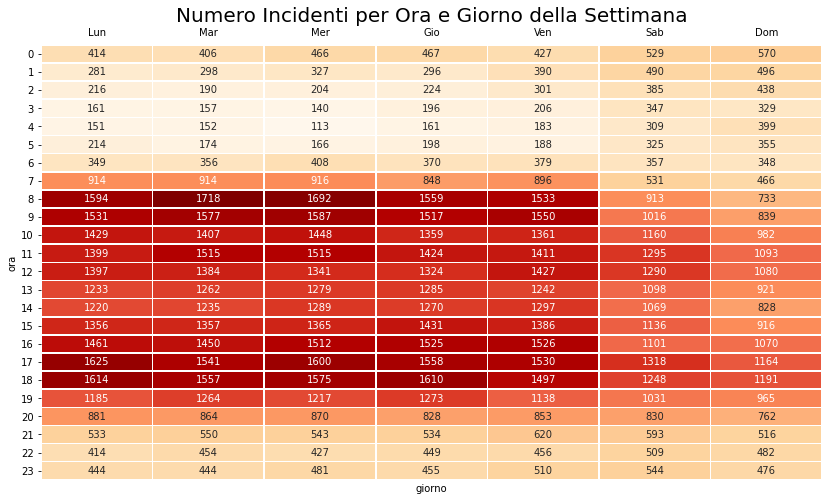

In [29]:
plt.figure(figsize=(14,8))
sns.heatmap(merged_tot, annot=True, linewidths=0.6, fmt='g', cmap='OrRd', cbar=False).set_title('Numero Incidenti per Ora e Giorno della Settimana', fontsize=20)
xticks_labels = ['Lun','Mar','Mer','Gio','Ven','Sab','Dom']
plt.xticks(np.arange(7) + .5,labels=xticks_labels)
plt.yticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)



In [30]:
merged_feriti = merged.groupby(['ora','giorno'])['NUM_FERITI'].sum().unstack()

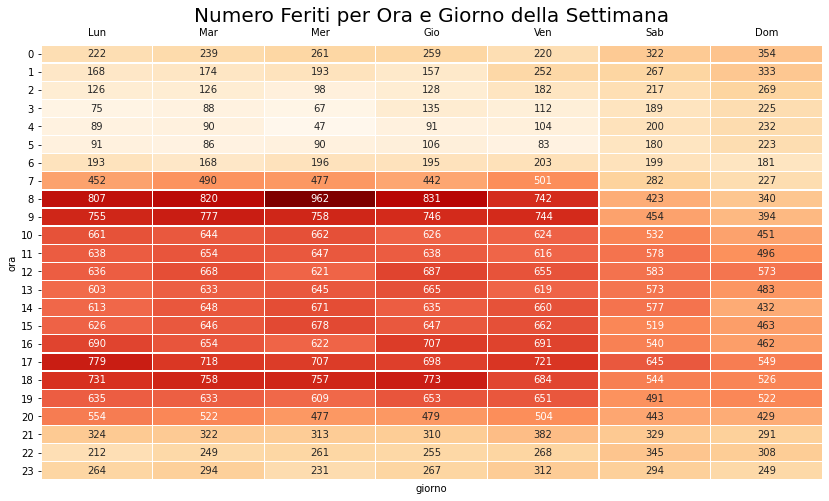

In [31]:
plt.figure(figsize=(14,8))
sns.heatmap(merged_feriti, annot=True, linewidths=0.3, fmt='g', cmap='OrRd', cbar=False).set_title('Numero Feriti per Ora e Giorno della Settimana', fontsize=20)
xticks_labels = ['Lun','Mar','Mer','Gio','Ven','Sab','Dom']
plt.xticks(np.arange(7) + .5,labels=xticks_labels)
plt.yticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)



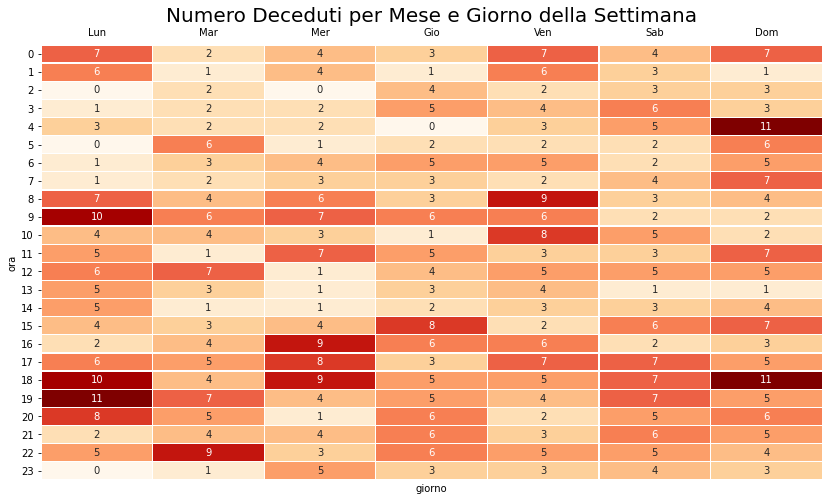

In [32]:
merged_deceduti = merged.groupby(['ora','giorno'])['NUM_MORTI'].sum().unstack()
plt.figure(figsize=(14,8))
sns.heatmap(merged_deceduti, annot=True, linewidths=0.3, fmt='g', cmap='OrRd', cbar=False).set_title('Numero Deceduti per Mese e Giorno della Settimana', fontsize=20)
xticks_labels = ['Lun','Mar','Mer','Gio','Ven','Sab','Dom']
plt.xticks(np.arange(7) + .5,labels=xticks_labels)
plt.yticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)



### Analisi per Mese/Giorno della settimana

In [33]:
mesi = ['Gen','Feb','Mar','Apr','Mag','Giu','Lug','Ago','Set','Ott','Nov','Dic']

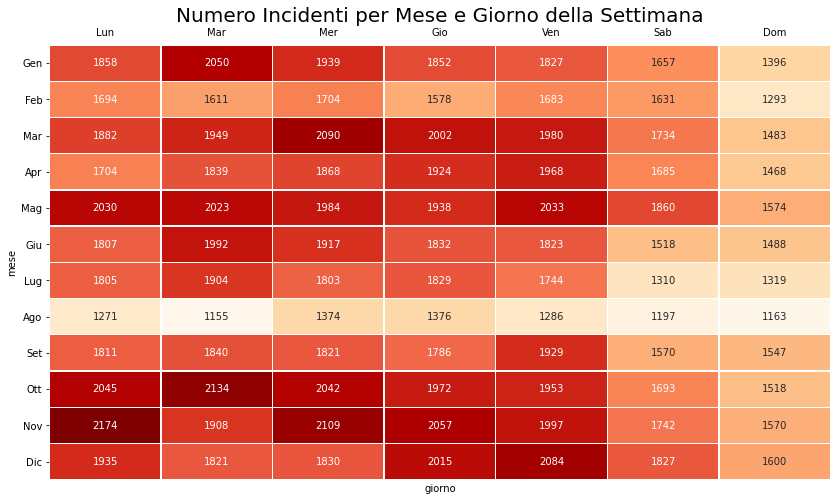

In [34]:
merged_m_tot = merged.groupby(['mese','giorno'])['Protocollo'].count().unstack()
plt.figure(figsize=(14,8))
sns.heatmap(merged_m_tot, annot=True, linewidths=0.3, fmt='g', cmap='OrRd', cbar=False).set_title('Numero Incidenti per Mese e Giorno della Settimana', fontsize=20)
plt.xticks(np.arange(7) + .5,labels=xticks_labels)
plt.yticks(np.arange(12) + .5,labels=mesi)
plt.yticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)



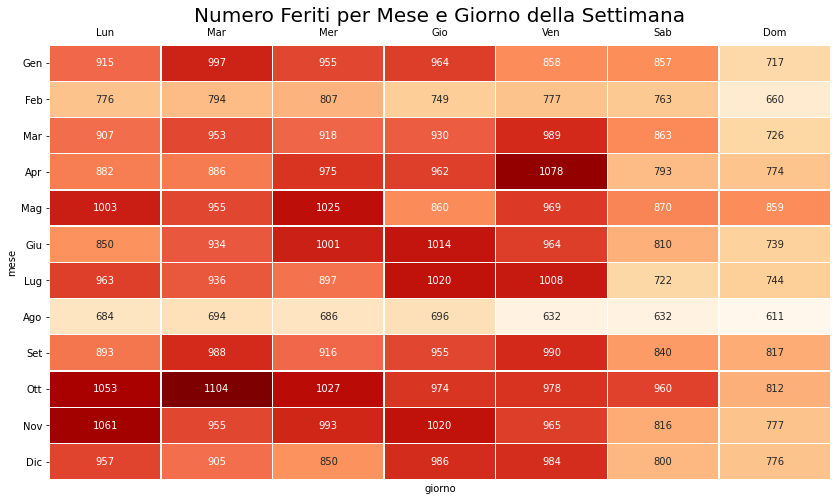

In [35]:
merged_m_feriti = merged.groupby(['mese','giorno'])['NUM_FERITI'].sum().unstack()
plt.figure(figsize=(14,8))
sns.heatmap(merged_m_feriti, annot=True, linewidths=0.3, fmt='g', cmap='OrRd', cbar=False).set_title('Numero Feriti per Mese e Giorno della Settimana', fontsize=20)
plt.yticks(np.arange(12) + .5,labels=mesi)
plt.yticks(rotation=0)
plt.xticks(np.arange(7) + .5,labels=xticks_labels)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)


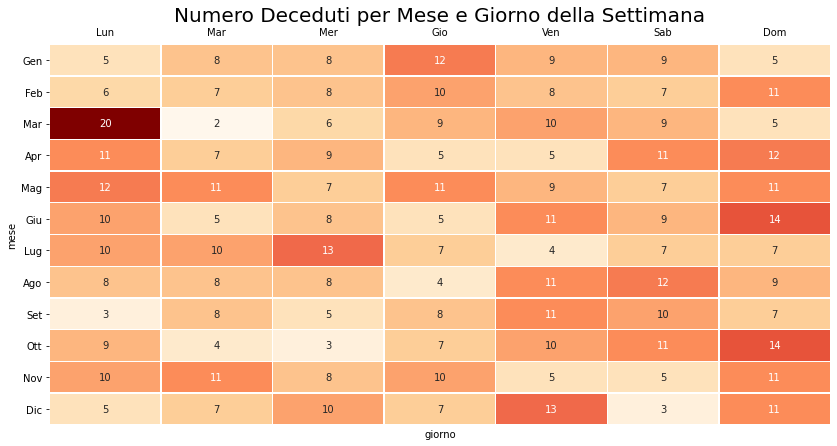

In [36]:
merged_m_deceduti = merged.groupby(['mese','giorno'])['NUM_MORTI'].sum().unstack()
plt.figure(figsize=(14,7))
sns.heatmap(merged_m_deceduti, annot=True, linewidths=0.3, fmt='g', cmap='OrRd', cbar=False).set_title('Numero Deceduti per Mese e Giorno della Settimana', fontsize=20)
plt.yticks(np.arange(12) + .5,labels=mesi)
plt.yticks(rotation=0)
plt.xticks(np.arange(7) + .5,labels=xticks_labels)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

### Tipo Strada / Condizioni

In [37]:
merged.head()

Protocollo    DataOraIncidente Localizzazione1  ... giorno ora mese
0     2242463 2015-01-01 00:40:00   Strada Urbana  ...      3   0    1
1     2252852 2015-01-01 00:45:00   Strada Urbana  ...      3   0    1
2     2245421 2015-01-01 01:00:00   Strada Urbana  ...      3   1    1
3     2242429 2015-01-01 01:20:00   Strada Urbana  ...      3   1    1
4     2242301 2015-01-01 02:30:00   Strada Urbana  ...      3   2    1

[5 rows x 26 columns]

In [38]:
merged.groupby(['particolaritastrade','TipoPersona','Sesso'])['Protocollo'].count().unstack().fillna(0).reset_index()

Sesso                      particolaritastrade  ...        M
0                                   Cavalcavia  ...    184.0
1                                   Cavalcavia  ...      1.0
2                                   Cavalcavia  ...      1.0
3                                      Cunetta  ...      1.0
4                                      Cunetta  ...      0.0
5                       Curva a visuale libera  ...   5164.0
6                       Curva a visuale libera  ...     39.0
7                       Curva a visuale libera  ...    186.0
8                   Curva senza visuale libera  ...   2304.0
9                   Curva senza visuale libera  ...     26.0
10                  Curva senza visuale libera  ...     47.0
11                                       Dosso  ...     57.0
12                                       Dosso  ...      0.0
13                                       Dosso  ...      0.0
14                         Galleria illuminata  ...    315.0
15                         Galleria illuminata  ...      2.0
16                         Galleria illuminata  ...      1.0
17                     Galleria non illuminata  ...     24.0
18                     Galleria non illuminata  ...      0.0
19                                    Incrocio  ...  18399.0
20                                    Incrocio  ...     93.0
21                                    Incrocio  ...    624.0
22     Intersezione non regolata/non segnalata  ...   1252.0
23     Intersezione non regolata/non segnalata  ...      6.0
24     Intersezione non regolata/non segnalata  ...     52.0
25            Intersezione regolata dal vigile  ...     12.0
26            Intersezione regolata dal vigile  ...      2.0
27                  Intersezione semaforizzata  ...   8231.0
28                  Intersezione semaforizzata  ...     48.0
29                  Intersezione semaforizzata  ...    309.0
30             Intersezione stradale segnalata  ...   4729.0
31             Intersezione stradale segnalata  ...     27.0
32             Intersezione stradale segnalata  ...    167.0
33             Passaggio a livello (custodito)  ...      1.0
34             Passaggio a livello (custodito)  ...      1.0
35           Passaggio a livello (incustodito)  ...      3.0
36           Passaggio a livello (incustodito)  ...      0.0
37                                    Pendenza  ...    859.0
38                                    Pendenza  ...      9.0
39                                    Pendenza  ...     44.0
40                                Pianeggiante  ...     55.0
41                                Pianeggiante  ...      1.0
42                                Pianeggiante  ...      2.0
43                                  Rettilineo  ...  52632.0
44                                  Rettilineo  ...    473.0
45                                  Rettilineo  ...   3317.0
46                                  Rettilineo  ...      1.0
47                                   Rotatoria  ...   2398.0
48                                   Rotatoria  ...     17.0
49                                   Rotatoria  ...     80.0
50                       Sottopasso illuminato  ...    115.0
51                       Sottopasso illuminato  ...      0.0
52                       Sottopasso illuminato  ...      0.0
53                   Sottopasso non illuminato  ...     36.0
54                   Sottopasso non illuminato  ...      0.0
55                   Sottopasso non illuminato  ...      1.0
56                                   Strettoia  ...     35.0
57                                   Strettoia  ...      1.0

[58 rows x 4 columns]

# Machine Learning

Utilizzo di un modello Random Forest per identificare i predittori del numero di feriti. Per migliorare il modello bisognera' introdurre un classifier per indicare la gravita' dell'incidente (morti+feriti) e farlo girare di nuovo

In [39]:
ml = merged[['NaturaIncidente','particolaritastrade',	'TipoStrada',	'FondoStradale',	'Segnaletica'	,'CondizioneAtmosferica'	,'Traffico',	'Illuminazione', 'NUM_FERITI']]

In [40]:
ml = ml.replace(np.nan, 'None', regex=True)

In [41]:
ml.head()

NaturaIncidente  ... NUM_FERITI
0                   Investimento di pedone  ...          1
1   Scontro laterale fra veicoli in marcia  ...          0
2  Veicolo in marcia contro ostacolo fisso  ...          2
3   Scontro laterale fra veicoli in marcia  ...          0
4   Scontro laterale fra veicoli in marcia  ...          3

[5 rows x 9 columns]

In [42]:
categories = ml.columns[ml.columns != 'NUM_FERITI']
ml_d = pd.get_dummies(ml, columns=categories)

from sklearn.preprocessing import LabelEncoder
lblE = LabelEncoder()
for i in ml:
    if ml[i].dtype == 'object':
        lblE.fit(ml[i])
        ml[i] = lblE.transform(ml[i])

In [43]:
from sklearn.model_selection import train_test_split


In [44]:
X_train, X_test, y_train, y_test = train_test_split(ml_d.drop('NUM_FERITI', axis=1), ml_d.NUM_FERITI, test_size=0.35, random_state=42)

In [45]:
from sklearn.ensemble import RandomForestRegressor


In [46]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), 
           rmse(m.predict(X_test), y_test),
           m.score(X_train, y_train), 
           m.score(X_test, y_test)]
    
    if hasattr(m, 'oob_score_'):res.append(m.oob_score_)
    print (res)

In [47]:
m = RandomForestRegressor(n_estimators=50)
m.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [48]:
print_score(m)


[0.6696132674425137, 0.7590763745981809, 0.2655976283661452, -0.006029591204486318]


In [49]:
f_imp = pd.DataFrame(data={'importance':m.feature_importances_,'features':X_train.columns}).set_index('features')
f_imp = f_imp.sort_values('importance', ascending=False)
f_imp.head(15)

importance
features                                                      
NaturaIncidente_Investimento di pedone                0.086821
TipoStrada_Una carreggiata a doppio senso             0.079823
NaturaIncidente_Veicolo in marcia contro ostaco...    0.043808
NaturaIncidente_Scontro laterale fra veicoli in...    0.043165
Segnaletica_Verticale ed orizzontale                  0.042594
CondizioneAtmosferica_Sereno                          0.038435
NaturaIncidente_Veicolo in marcia contro veicol...    0.037219
Illuminazione_Ore Diurne                              0.033933
Segnaletica_Assente                                   0.033850
CondizioneAtmosferica_Nuvoloso                        0.031584
Illuminazione_Sufficiente                             0.027591
Traffico_Scarso                                       0.025876
Traffico_Normale                                      0.025639
particolaritastrade_Curva a visuale libera            0.022952
Segnaletica_Orizzontale                               0.021993

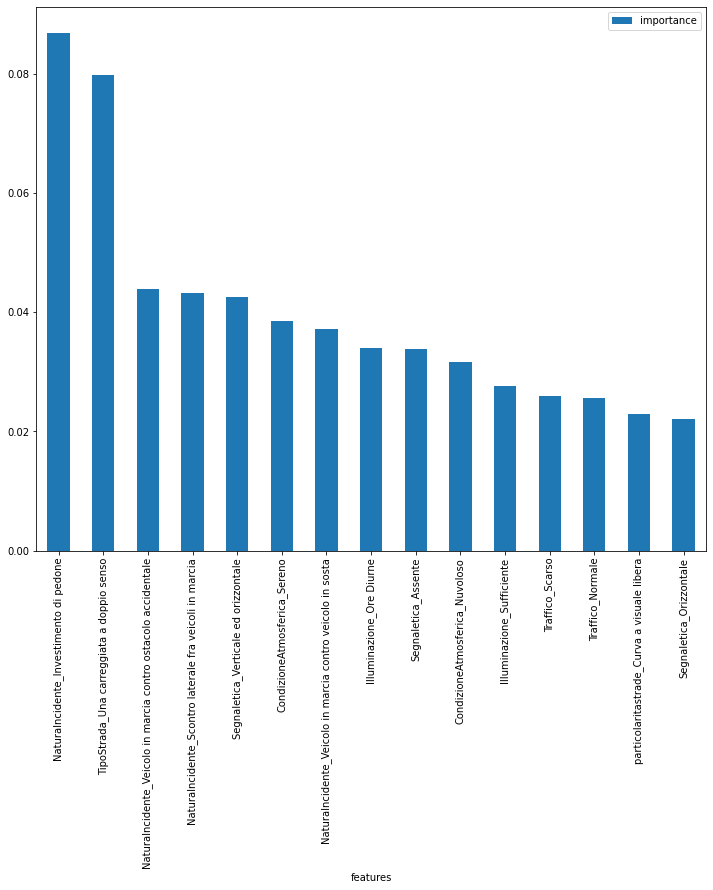

In [50]:
f_imp[:15].plot(kind='bar', figsize=(12,10),)


# Geo Viz

In [51]:
fig = px.density_mapbox(merged, lat='Latitudine', lon='Longitudine', z=merged.Protocollo.count(), radius=6,
                        center=dict(lat=41.9028, lon=12.4964), zoom=11.5,
                        mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [52]:
start = [41.9028, 12.4964]
rome = folium.Map(location=start, zoom_start=11)

In [53]:
cluster = merged.dropna(subset=['Latitudine','Longitudine'], how='any')
cluster.Latitudine = pd.to_numeric(cluster.Latitudine, errors='coerce').astype(float)
cluster.Longitudine = pd.to_numeric(cluster.Longitudine, errors='coerce').astype(float)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
cluster.dropna(subset=['Latitudine','Longitudine'], how='any', inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
loc = cluster[['Latitudine', 'Longitudine']].values


### In Colab it throws a "Maximum Recursion" error - try in Jupyter

map saves as html but takes a long time

try subsetting for "incidenti gravi" with conditions such as NUM_FERITI > 2 & NUM_MORTI > 0




```
# rome.add_child(plugins.MarkerCluster(loc))
rome.save('rome.html')
```

rome.add_child(plugins.MarkerCluster(loc))
rome.save('rome.html')

### Choropleth

In [56]:
# GeoJson Manipulation
# Trying to change the MUNICIPIO property into 'ID' which can be read by the Choroplex class in Plotly

In [57]:
with open('/content/drive/My Drive/Colab Notebooks/Roma/Inc_Roma_2019/data/ROMA_MUNICIPI.geojson', encoding='latin1') as f:
    municipi = json.load(f)

In [58]:
for k in range(len(municipi['features'])):
    municipi['features'][k]['id'] = municipi['features'][k]['properties']['MUNICIPIO']

for feature in municipi['features']: 
    feature['properties']['id'] = feature['properties'].pop('MUNICIPIO')

for feature in municipi['features']:
  municipi['id'] = feature['properties']['MUNICIPIO']

In [59]:
chorodata = merged.groupby('municipio')[['Protocollo']].count().reset_index()


In [60]:
fig = px.choropleth_mapbox(chorodata, geojson=municipi, locations=chorodata.municipio, color=chorodata.Protocollo,
                           color_continuous_scale="Viridis",
                           range_color=(4116, 10636),
                           mapbox_style="carto-positron",
                           zoom=8, center = {'lat': 41.9028,'lon': 12.4964},
                           opacity=0.5,
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [61]:
folium.Choropleth(
 geo_data=municipi,
 name='choropleth',
 data=chorodata,
 columns=['municipio', 'Protocollo'],
 key_on='properties.DENOMINAZI',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Unemployment Rate (%)'
)
folium.LayerControl().add_to(rome)
rome.save('chororome.html')


# Data Extraction from Municipi GeoJson

In [62]:
ids = []
features = municipi['features']
for i in features:
  ids.append(i['properties'])


In [63]:
mun_df = pd.json_normalize(ids)
mun_df = mun_df[['DENOMINAZI','POP2011','MUNICIPIO']]
mun_df.head(3)

DENOMINAZI   POP2011 MUNICIPIO
0   Municipio Roma XV  158222.0        15
1  Citta del Vaticano       0.0       CDV
2    Municipio Roma I  197258.0         1

# Analisi per Popolazione
data loss issues

In [64]:
mun_grouped = merged.groupby('municipio', as_index=False)[['Protocollo','NUM_FERITI','NUM_MORTI']].agg({'Protocollo':'count','NUM_FERITI':'sum','NUM_MORTI':'sum'})

#### Data loss as viario.csv refers to pre-2013 areas (20) whereas the current number of areas is 15

In [65]:
mun_merged = mun_grouped.merge(mun_df, left_on='municipio', right_on='MUNICIPIO')

In [66]:
mun_merged['inc_10k'] = (mun_merged['Protocollo'] / mun_merged['POP2011']) *10000
mun_merged['feriti_10k'] = (mun_merged['NUM_FERITI'] / mun_merged['POP2011']) *10000
mun_merged['morti_10k'] = (mun_merged['NUM_MORTI'] / mun_merged['POP2011']) *10000
mun_merged = mun_merged.round(1)

In [67]:
mun_merged.municipio.unique()

array(['1', '10', '11', '12', '13', '15', '2', '3', '4', '5', '6', '7',
       '8', '9'], dtype=object)

In [68]:
mun_merged.NUM_FERITI.sum()

55165

In [69]:
merged.NUM_FERITI.sum()

74155

In [70]:
merged.municipio.unique()

array(['1', '18', '12', '11', '2', '16', '8', '20', '6', '13', '9', '19',
       '3', '10', '17', '15', '5', nan, '4', '7'], dtype=object)

# Pedoni

Analisi sugli incidenti che coinvolgono i pedoni. I numeri sul quinquennio sono preoccupanti: 273 morti e 10.585 feriti. Gli investimenti di pedone rappresentano il 6.87 % della totalita' dei sinistri stradali ma causano il 14.27 % dei feriti totali e il 38.56 % dei deceduti sulle strade romane

In [71]:
pedoni = merged[merged.TipoPersona == 'Pedone']
pedoni.head(3)

Protocollo    DataOraIncidente Localizzazione1  ... giorno ora mese
0      2242463 2015-01-01 00:40:00   Strada Urbana  ...      3   0    1
83     2268662 2015-01-02 18:39:00   Strada Urbana  ...      4  18    1
92     2269028 2015-01-02 21:00:00   Strada Urbana  ...      4  21    1

[3 rows x 26 columns]

In [72]:
(pedoni.Protocollo.count()/merged.Protocollo.count()*100).round(2)
(pedoni.NUM_FERITI.sum()/merged.NUM_FERITI.sum()*100).round(2)
(pedoni.NUM_MORTI.sum()/merged.NUM_MORTI.sum()*100).round(2)

38.56

In [73]:
# Vie piu' pericolose per i pedoni

vie_pedoni = pedoni.groupby('STRADA1')[['Protocollo']].count().sort_values(by='Protocollo',ascending=False).head(8)
fig = px.bar(vie_pedoni, x=vie_pedoni.Protocollo.sort_values(),y=vie_pedoni.index, orientation='h', color='Protocollo', color_continuous_scale='OrRd_r',
             labels=dict(x='Numero Incidenti'),
             width=1200)
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [74]:
pedoni.groupby(pedoni.DataOraIncidente.dt.year)['Protocollo'].count()

DataOraIncidente
2015    2001
2016    2019
2017    2044
2018    2003
2019    2099
Name: Protocollo, dtype: int64

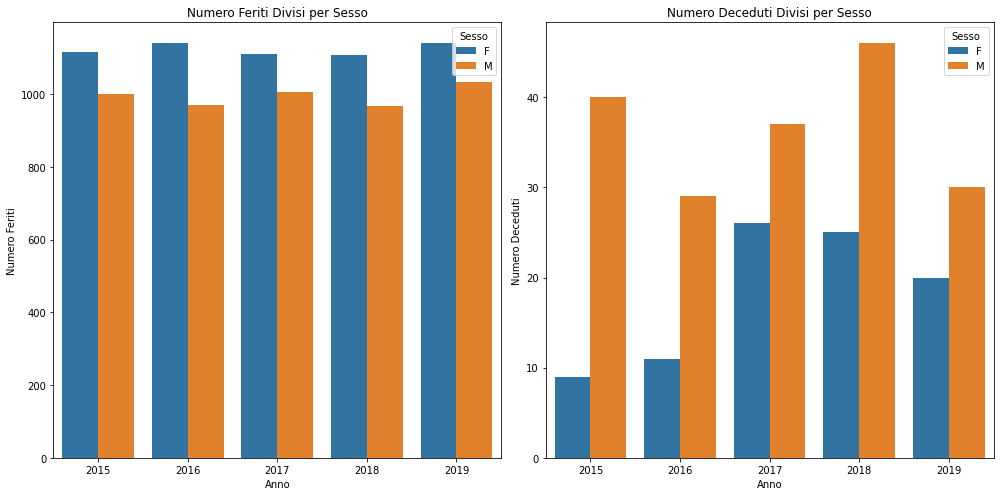

In [75]:
yearly = pedoni.groupby([pedoni.DataOraIncidente.dt.year,'Sesso'])[['Protocollo','NUM_FERITI', 'NUM_MORTI']].agg({'Protocollo':'count','NUM_FERITI':'sum','NUM_MORTI':'sum'})
yearly.reset_index(inplace=True)

fig, ax =plt.subplots(1,2, figsize=(14,7))

sns.barplot(x='DataOraIncidente', y='NUM_FERITI', hue='Sesso', data=yearly, ax=ax[0]).set_title('Numero Feriti Divisi per Sesso')
sns.barplot(x='DataOraIncidente', y='NUM_MORTI', hue='Sesso', data=yearly, ax=ax[1]).set_title('Numero Deceduti Divisi per Sesso')
ax[0].set(xlabel='Anno', ylabel='Numero Feriti')
ax[1].set(xlabel='Anno', ylabel='Numero Deceduti')
fig.tight_layout()
fig.show()


In [76]:
yearly.set_index('DataOraIncidente', inplace=True)
yearly.loc['Totale'] = yearly.sum()
yearly.drop('Sesso', axis=1, inplace=True)
yearly

Protocollo  NUM_FERITI  NUM_MORTI
DataOraIncidente                                   
2015                    1026        1115          9
2015                     975         999         40
2016                    1072        1139         11
2016                     947         971         29
2017                    1054        1109         26
2017                     990        1006         37
2018                    1030        1107         25
2018                     973         967         46
2019                    1080        1140         20
2019                    1019        1032         30
Totale                 10166       10585        273

In [77]:
ora_giorno = pedoni.groupby(['ora','giorno'])[['Protocollo','NUM_FERITI', 'NUM_MORTI']].agg({'Protocollo':'count','NUM_FERITI':'sum','NUM_MORTI':'sum'}).unstack().fillna(0)

#### Analisi per ora/giorno della settimana e numero di feriti

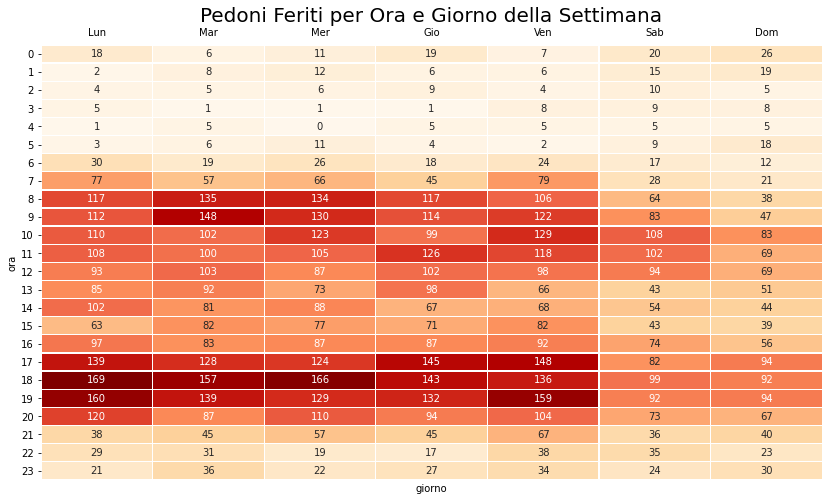

In [78]:
plt.figure(figsize=(14,8))
sns.heatmap(ora_giorno.NUM_FERITI, annot=True, linewidths=0.3, fmt='g', cmap='OrRd', cbar=False).set_title('Pedoni Feriti per Ora e Giorno della Settimana', fontsize=20)
xticks_labels = ['Lun','Mar','Mer','Gio','Ven','Sab','Dom']
plt.xticks(np.arange(7) + .5,labels=xticks_labels)
plt.yticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

#### Analisi per ora/giorno della settimana e numero di deceduti

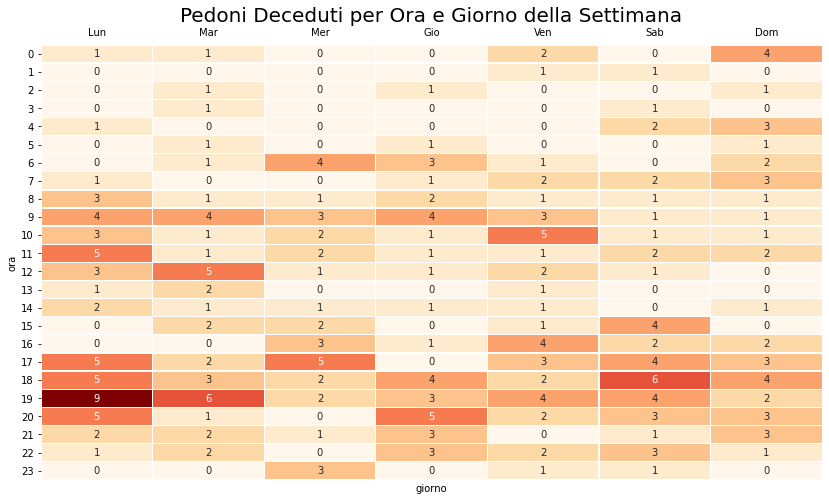

In [79]:
plt.figure(figsize=(14,8))
sns.heatmap(ora_giorno.NUM_MORTI, annot=True, linewidths=0.3, fmt='g', cmap='OrRd', cbar=False).set_title('Pedoni Deceduti per Ora e Giorno della Settimana', fontsize=20)
xticks_labels = ['Lun','Mar','Mer','Gio','Ven','Sab','Dom']
plt.xticks(np.arange(7) + .5,labels=xticks_labels)
plt.yticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

In [80]:
tipos_pedoni = pedoni.groupby('TipoStrada')[['Protocollo']].count().sort_values(by='Protocollo',ascending=False).head(4)
fig = px.bar(tipos_pedoni, x=tipos_pedoni.Protocollo.sort_values(),y=tipos_pedoni.index, orientation='h', color='Protocollo', color_continuous_scale='OrRd_r',
             labels=dict(x='Numero Incidenti'),
             width=1200)
fig.update(layout_coloraxis_showscale=False)
fig.show()

#### Geo Viz

In [81]:
# Mappa pedoni feriti

fig = px.density_mapbox(pedoni, lat='Latitudine', lon='Longitudine', z=pedoni.NUM_FERITI, radius=14,
                        center=dict(lat=41.9028, lon=12.4964), zoom=11.5,
                        mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [82]:
# Mappa pedoni deceduti (mancano 48 decessi per mancanza di coordinate)

pedoni_dec = pedoni[pedoni.NUM_MORTI > 0]
start = [41.9028, 12.4964]
rome = folium.Map(location=start, zoom_start=11)
cluster = pedoni_dec.dropna(subset=['Latitudine','Longitudine'], how='any')
cluster.Latitudine = pd.to_numeric(cluster.Latitudine, errors='coerce').astype(float)
cluster.Longitudine = pd.to_numeric(cluster.Longitudine, errors='coerce').astype(float)
cluster.dropna(subset=['Latitudine','Longitudine'], how='any', inplace=True)
loc = cluster[['Latitudine', 'Longitudine']].values
rome.add_child(plugins.MarkerCluster(loc, popups=pedoni_dec.DataOraIncidente.dt.strftime('%d/%m/%Y-%H:%M')))
rome


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Conseguenze Incidenti

In [83]:
lesioni = pedoni.groupby('Tipolesione')[['Protocollo']].count().reset_index()
lesioni

Tipolesione  Protocollo
0  Deceduto durante prime cure          73
1   Deceduto durante trasporto          14
2           Deceduto sul posto          66
3                       Illeso         849
4           Prognosi riservata         400
5                   Ricoverato        1334
6       Rifiuta cure immediate         489
7                    Rimandato        6941

In [84]:
list(lesioni.Tipolesione)

['Deceduto durante prime cure',
 'Deceduto durante trasporto',
 'Deceduto sul posto',
 'Illeso',
 'Prognosi riservata',
 'Ricoverato',
 'Rifiuta cure immediate',
 'Rimandato']

In [85]:
lesioni['gravita'] = np.where((lesioni.Tipolesione == 'Illeso')|(lesioni.Tipolesione == 'Rimandato')|(lesioni.Tipolesione == 'Rifiuta cure immediate'), 'non grave', 'grave')

In [86]:
lesioni.groupby('gravita')['Protocollo'].sum()

gravita
grave        1887
non grave    8279
Name: Protocollo, dtype: int64

In [87]:
pedoni.query('2<NUM_FERITI<6 & 0<NUM_MORTI<3')

Protocollo    DataOraIncidente Localizzazione1  ... giorno ora mese
110        2296398 2015-01-03 09:30:00   Strada Urbana  ...      5   9    1
4829       2270774 2015-03-02 19:45:00   Strada Urbana  ...      0  19    3
125231     4212832 2019-04-01 19:20:00   Strada Urbana  ...      0  19    4

[3 rows x 26 columns]

# Analisi Incroci & Strade Pericolose

In [89]:
df

Protocollo  Gruppo    DataOraIncidente  ... Unnamed: 37 Longitude Latitude
44       2242463       1 2015-01-01 00:40:00  ...         NaN       NaN      NaN
2283     2252852       1 2015-01-01 00:45:00  ...         NaN       NaN      NaN
611      2245421      18 2015-01-01 01:00:00  ...         NaN       NaN      NaN
36       2242429      12 2015-01-01 01:20:00  ...         NaN       NaN      NaN
8        2242301      11 2015-01-01 02:30:00  ...         NaN       NaN      NaN
...          ...     ...                 ...  ...         ...       ...      ...
7009     4733156       6 2019-12-31 20:05:00  ...         NaN   12.5421  41.8906
7049     4733260       1 2019-12-31 20:45:00  ...         NaN   12.5022  41.8914
7059     4733275      18 2019-12-31 20:50:00  ...         NaN   12.4332  41.9171
7022     4733196       6 2019-12-31 21:25:00  ...         NaN   12.5644  41.8764
7027     4733210      19 2019-12-31 22:00:00  ...         NaN   12.3964  41.9203

[148034 rows x 40 columns]

In [263]:
prova = df.groupby(['STRADA1','STRADA2'])['Protocollo','NUM_FERITI'].agg({'Protocollo':'count','NUM_FERITI':'sum'}).sort_values(by='NUM_FERITI',ascending=False)
prova = prova.reset_index().head(12)
prova['Incrocio']=prova[['STRADA1','STRADA2']].values.tolist()
cols = prova.columns.tolist()
cols = cols[-1:] + cols[:-1]
prova = prova[cols]
prova.drop(columns=['STRADA1','STRADA2'], inplace=True)
prova['Incrocio'] = prova['Incrocio'].apply(' / '.join)
prova.Incrocio = prova.Incrocio.str.title()
prova['Feriti per Incidente'] = (prova.NUM_FERITI/prova.Protocollo).round(1)
prova.rename(columns={'Protocollo':'Numero Incidenti','NUM_FERITI':'Numero Feriti'},inplace=True)
styled = prova.style.format({'Feriti per Incidente':"{:20,.1f}"}).bar(subset=["Numero Feriti"], color='#F32626').bar(subset=["Numero Incidenti"], color='#F32626').bar(subset=["Feriti per Incidente"], color='#F32626').hide_index()
styled

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [268]:
f=open("styled_dataframe.png","w")
f.write(styled.render()) # df is the styled dataframe
f.close()


In [245]:
incroci = df.groupby(['STRADA1','STRADA2'])['TipoPersona'].value_counts().unstack().fillna(0)
incroci = incroci.query("Pedone>0").sort_values(by="Pedone",ascending=False).head(5).reset_index()
incroci['Incrocio']=incroci[['STRADA1','STRADA2']].values.tolist()
incroci['Incrocio'] = incroci['Incrocio'].apply(' / '.join)
incroci.Incrocio = incroci.Incrocio.str.title()
incroci.drop(columns=['STRADA1', 'STRADA2', 'Conducente', 'Passeggero','Pedone sconosciuto'], inplace=True)

In [258]:
incroci = incroci[incroci.columns[::-1]]


In [260]:
incroci.set_index('Incrocio')

TipoPersona                                         Pedone
Incrocio                                                  
Piazza Vittorio Emanuele Ii / Via Mamiani             13.0
Via Cristoforo Colombo / Viale Europa                  9.0
Via Laurentina / Via Dei Corazzieri                    9.0
Via Crescenzio / Via Properzio                         9.0
Piazza Dei Giureconsulti / Circonvallazione Cor...     7.0